# How to use AUTOENCODIX with single-cell data

As shown in the [set-up tutorial](Setup_InputFormat.ipynb), our framework requires as input format text- or `.parquet`-files for each data modality and to work with multi-omics data. To be able to work with single-cell data, which comes typically as a single-file in the `anndata` format, we offer preprocessing support for `.h5ad`-files via `make format_singlecell RUN_ID=<run_id>`.

This will create the necessary input files for `AUTOENCODIX`, extracts data layers and pre-filtering for highly variable genes or exclusion of cells with sparse data. 

## Single-cell example: scRNA and RNA velocity to train `ontix`
In this tutorial we will use a small example data set with scRNA and velocity data as shown in [scVelo tutorial](https://scvelo.readthedocs.io/en/stable/VelocityBasics.html) of endocrine development in the pancreas. 

We will use this data to show how the data can be easily preprocessed and both data modalities incorporated to train VAE with explainable latent space `ontix`.

### Step 1: Get the `h5ad` data file
You can either follow the [scVelo tutorial](https://scvelo.readthedocs.io/en/stable/VelocityBasics.html) and save the resulting data as  `h5ad` or directly download the file with RNA velocity like this:

In [1]:
## Download example data
!wget https://cloud.scadsai.uni-leipzig.de/index.php/s/kmGkAzEw3wGZC95/download/scvelo_01_pancreas_adata_ncbi.h5ad
## move to data/raw
!mv ./scvelo_01_pancreas_adata_ncbi.h5ad ../data/raw/

--2024-08-16 11:14:38--  https://cloud.scadsai.uni-leipzig.de/index.php/s/kmGkAzEw3wGZC95/download/scvelo_01_pancreas_adata_ncbi.h5ad
Auflösen des Hostnamens cloud.scadsai.uni-leipzig.de (cloud.scadsai.uni-leipzig.de) … 139.18.13.37
Verbindungsaufbau zu cloud.scadsai.uni-leipzig.de (cloud.scadsai.uni-leipzig.de)|139.18.13.37|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 146049272 (139M) [application/octet-stream]
Wird in ‘scvelo_01_pancreas_adata_ncbi.h5ad’ gespeichert.

scvelo_01_pancreas_ 100%[===================>] 139,28M  17,8MB/s    in 5,5s    

2024-08-16 11:14:44 (25,2 MB/s) - ‘scvelo_01_pancreas_adata_ncbi.h5ad’ gespeichert [146049272/146049272]



### Step 2: Define layers to be extracted via the config

In our case we will extract two data modality layers (scRNA and velocity) from the `anndata`-object and one `ANNOTATION` data modality with meta-data information for visualization. This is controlled via config options located in the internal config `src/000_internal_config.yaml` via option `H5AD_FILES` (list of files to format) and `ANNDATA_LAYER` (list of layers to extract).

For our example this should be defined as follows: 
```
H5AD_FILES:
  - "scvelo_01_pancreas_adata_velo.h5ad"

ANNDATA_LAYER:
  - "X"  
  - "obs" 
  - "layers/velocity"
```
Where `X` is the layer with scRNA data, `obs` the layer with meta-data information for plotting and `layers/velocity` extracting RNA velocity from `adata.layers`. 

This and other internal-config parameters can be either changed globally directly in `src/000_internal_config.yaml` or more specifically in your `<run_id>_config.yaml`. We recommend the latter to keep the internal-config parameters in general unchanged for other runs. 

For this tutorial our `scRNA-velo_config.yaml` will look like this:

In [1]:
## We will use Python for config defintion, but you can write your own yaml-config with an editor
import yaml
cfg = dict()

cfg['ANNDATA_LAYER'] = [
  "X",  # Standard data matrix adata.X
  "obs", # Keep adata.obs as clinical data for visualization
  "layers/velocity", # additional layer in adata
]

cfg['H5AD_FILES'] = [
  "scvelo_01_pancreas_adata_ncbi.h5ad"
]

# Ontix specific
cfg['MODEL_TYPE'] = "ontix" 
cfg['FILE_ONT_LVL1'] = "full_ont_lvl1_reactome.txt"
cfg['FILE_ONT_LVL2'] = "full_ont_lvl2_reactome_named.txt"
cfg['NON_ONT_LAYER'] = 0

# DATA DEFINITIONS ------------------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DATA_TYPE'] = dict()
# RNAseq
cfg['DATA_TYPE']['RNA'] = dict()
cfg['DATA_TYPE']['RNA']['SCALING'] = "Standard"	
cfg['DATA_TYPE']['RNA']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['RNA']['FILTERING'] = "Var"	
cfg['DATA_TYPE']['RNA']['FILE_RAW'] = "scvelo_01_pancreas_adata_ncbi_formatted.parquet"
# METH
cfg['DATA_TYPE']['VELO'] = dict()
cfg['DATA_TYPE']['VELO']['SCALING'] = "Standard"
cfg['DATA_TYPE']['VELO']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['VELO']['FILTERING'] = "Var"
cfg['DATA_TYPE']['VELO']['FILE_RAW'] = "scvelo_01_pancreas_adata_ncbi_velocity_formatted.parquet"
# Clinical Parameters for plotting
cfg['DATA_TYPE']['ANNO'] = dict()
cfg['DATA_TYPE']['ANNO']['TYPE'] = "ANNOTATION"
cfg['DATA_TYPE']['ANNO']['FILE_RAW'] = "scvelo_01_pancreas_adata_ncbi_clinical_formatted.parquet"

## Model and Training --------------------------------------------------------
# ----------------------------------------------------------------------------
# Reproducibility
cfg['FIX_RANDOMNESS'] = "all"
cfg['GLOBAL_SEED'] = 42
# Model
cfg['TRAIN_TYPE'] = "train" # simple training, no tuning
cfg['RECONSTR_LOSS'] = "MSE"	# loss function for reconstruction
cfg['VAE_LOSS'] = "KL"		# loss function distribution distance
cfg['BETA'] = 1			# weighting of VAE loss
cfg['K_FILTER'] = 500		# Input features per data modality
cfg["LATENT_DIM_FIXED"] = 23	# unused, since dimension is specified by ontology
# Training
cfg['EPOCHS'] = 500
cfg['LR_FIXED'] = 0.0005	# Learning rate
cfg['BATCH_SIZE'] = 128
cfg['DROP_P'] = 0.25			# Drop out
# Prediction
cfg['PREDICT_SPLIT'] = "all"	# Embedding of all samples should be calculated in prediction
# EVALUATION and VISUALIZATION ------------------------------------------------
# -----------------------------------------------------------------------------
cfg['PLOT_NUMERIC'] = True
cfg['DIM_RED_METH'] = "UMAP"	# For 2D visualization when LATENT_DIM_FIXED>2
cfg['CLINIC_PARAM'] = [			# Parameters to colorize plots and perform embedding evaluation
  "clusters_coarse", 
  "clusters",
  "G2M_score",
  "S_score",
  "velocity_self_transition",
  "initial_size",
  "n_genes"
			]


## save config
with open("../"+"scRNA-velo_config.yaml", 'w') as file:
	yaml.dump(cfg, file)

## Step 3 Pre-format single-cell data with AUTOENCODIX
When we specified everything in the config, we can perform the pre-formatting like this: 

In [1]:
# Make sure to start from project root folder
%cd .. 
# Activate venv
!source venv-gallia/bin/activate
# Start formatting
!make format_singlecell RUN_ID=scRNA-velo

/home/ewald/Github/autoencodix
done config
2025-04-11 11:39:09,432 - src.utils.utils_basic - INFO - Format single-cell files (h5ad)
2025-04-11 11:39:09,432 - src.utils.utils_basic - INFO - Formatting: scvelo_01_pancreas_adata_ncbi.h5ad
2025-04-11 11:39:09,432 - src.utils.utils_basic - INFO - Read in h5ad file
/home/ewald/Github/autoencodix/venv-gallia/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2025-04-11 11:39:09,547 - src.utils.utils_basic - INFO - Shape before: (3696, 1769)
2025-04-11 11:39:09,547 - src.utils.utils_basic - INFO - Filter samples with low number of expressed genes
2025-04-11 11:39:09,643 - src.utils.utils_basic - INFO - Shape after filtering: (3696, 1769)
2025-04-11 11:39:09,643 - src.utils.utils_basic - INFO - Filter genes which are lowly present in cells
2025-04-11 11:39:09,836 - src.utils.utils_basic - INFO - Shape afte

## Step 4 Run the `AUTOENCODIX` pipeline
Now the data and config is ready to run our pipeline:

In [2]:
# Setting CUBLAS for reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:16:8

!make visualize RUN_ID=scRNA-velo

env: CUBLAS_WORKSPACE_CONFIG=:16:8
done config
2025-04-11 11:39:22,659 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2025-04-11 11:39:22,810 - src.utils.utils_basic - INFO - Save sample split.
2025-04-11 11:39:22,815 - src.utils.utils_basic - INFO - Unified sample ID list has length 3696
2025-04-11 11:39:22,816 - src.utils.utils_basic - INFO - Make data set ANNO
2025-04-11 11:39:22,820 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2025-04-11 11:39:22,828 - src.utils.utils_basic - INFO - Make data set RNA
2025-04-11 11:39:22,882 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2025-04-11 11:39:22,902 - src.utils.utils_basic - INFO - Preprocessing of ontology files
2025-04-11 11:39:23,021 - src.utils.utils_basic - WARNING - Number of features not in ontology file: 420
2025-04-11 11:39:23,022 - src.utils.utils_basic - WARNING - Dropping features not in ontology.
2025-04-11 11:39:23,023 - src.utils.utils_basic - 

## Step 5 Inspecting the ontology-based latent dimensions
After training the ontology-based VAE `ontix` we can gain insights by the visualizations of the latent dimensions which represent [Reactome](https://reactome.org/content/schema/objects/TopLevelPathway) top-level pathways. But first we can have look at the 2D latent space representation of all latent dimensions for meta-data like cell clusters or cell-cyle scores:

2D latent space plot grouped by cell clusters


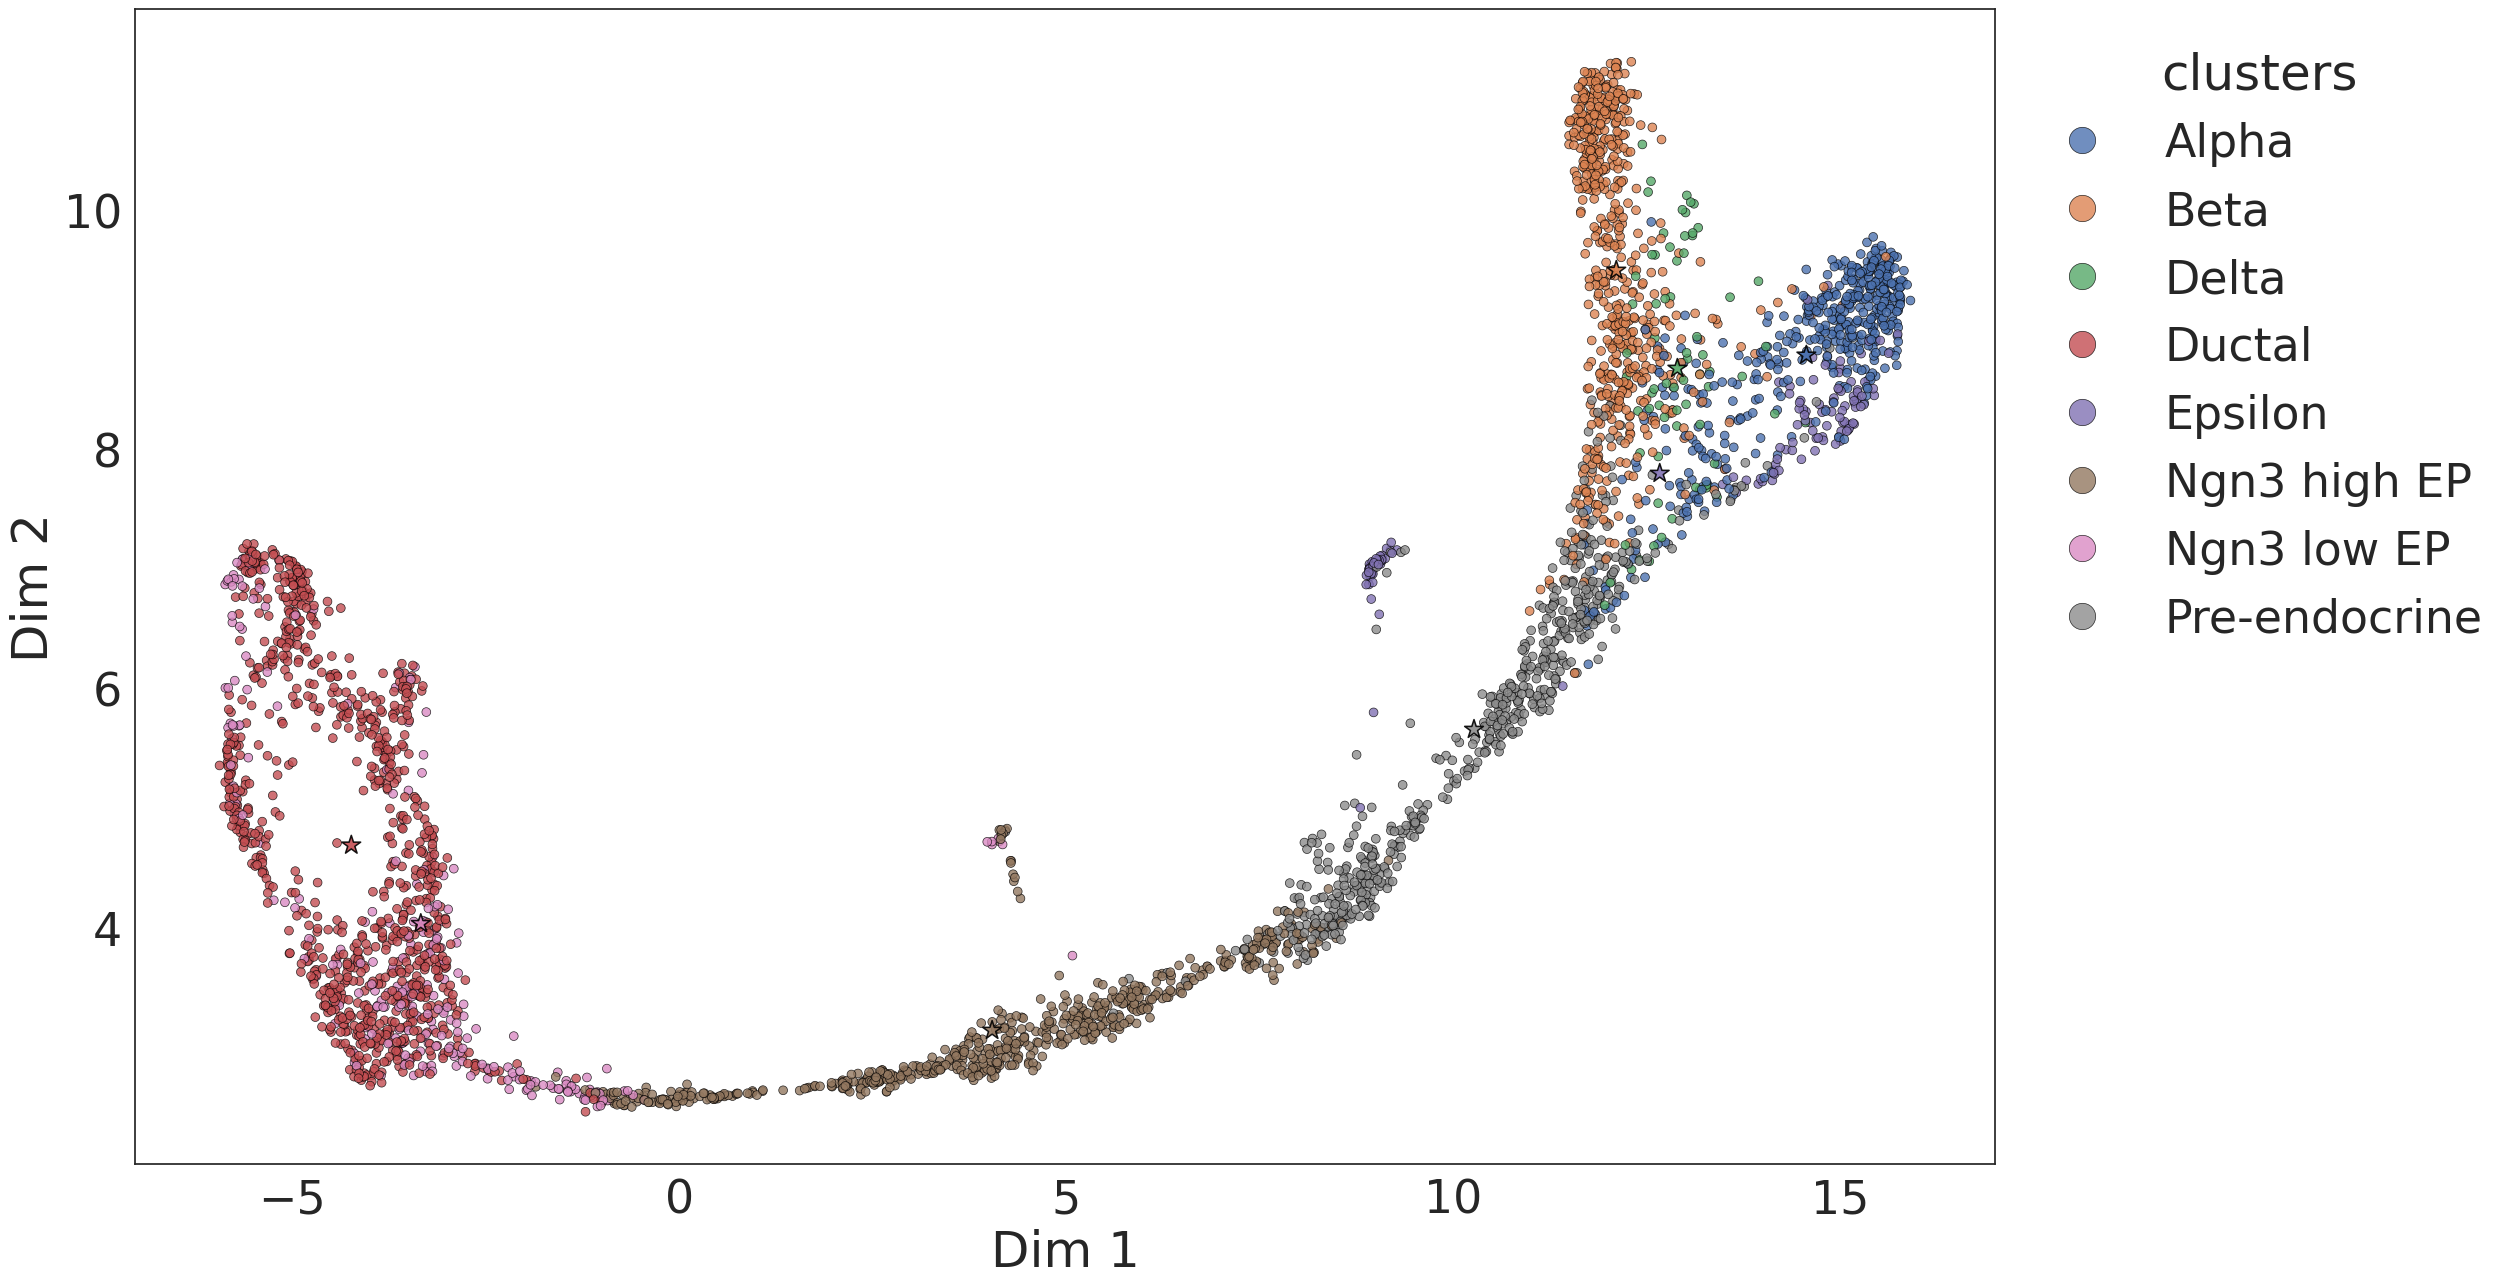

2D latent space plot by G2M score (cell cycle phase)


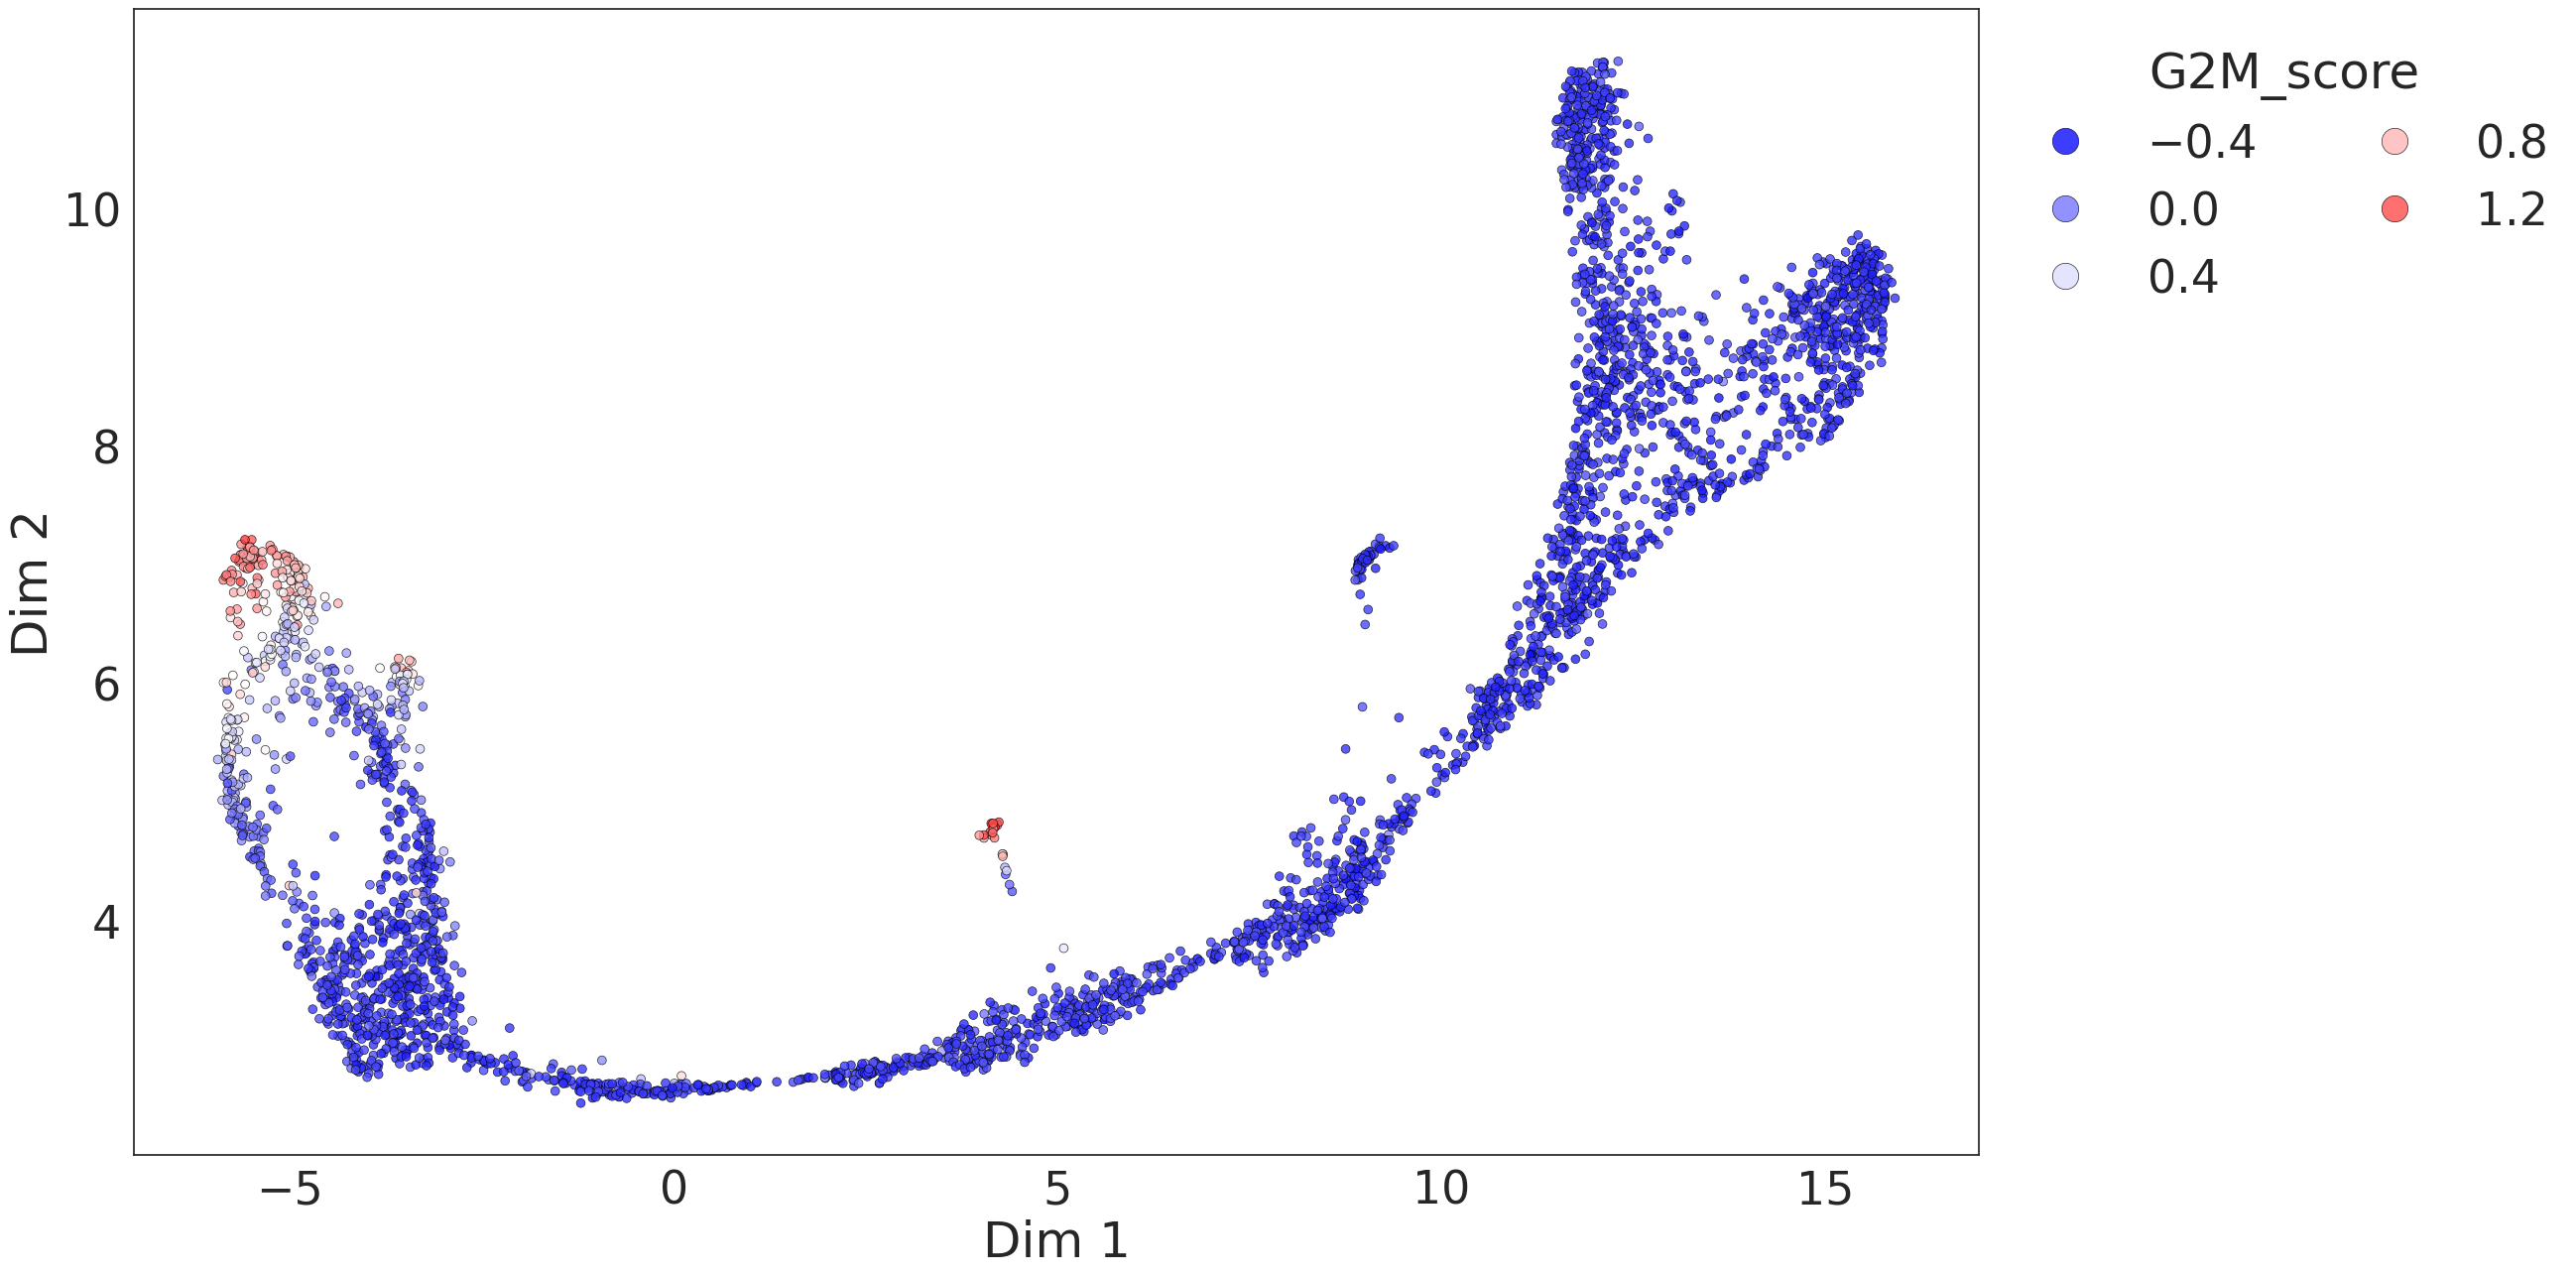

In [3]:
from IPython.display import Image
from IPython.display import display

latent2D_clusters = Image(filename='reports/scRNA-velo/figures/latent2D_clusters.png', width=800)
latent2D_G2M = Image(filename='reports/scRNA-velo/figures/latent2D_G2M_score.png', width=800)


print("2D latent space plot grouped by cell clusters")
display(latent2D_clusters)

print("2D latent space plot by G2M score (cell cycle phase)")
display(latent2D_G2M)

We can see that cell type clusters are re-identified by our ontology-based VAE. Further, we can assume and check if cells with high G2M-Score are distinct in latent dimensions associated to top-level pathways like 'Cell Cycle' or 'Signal Transduction'. So let's check this via the plot of latent intensities: 

Latent intensitiy plot grouped by G2M score (cell cycle phase)


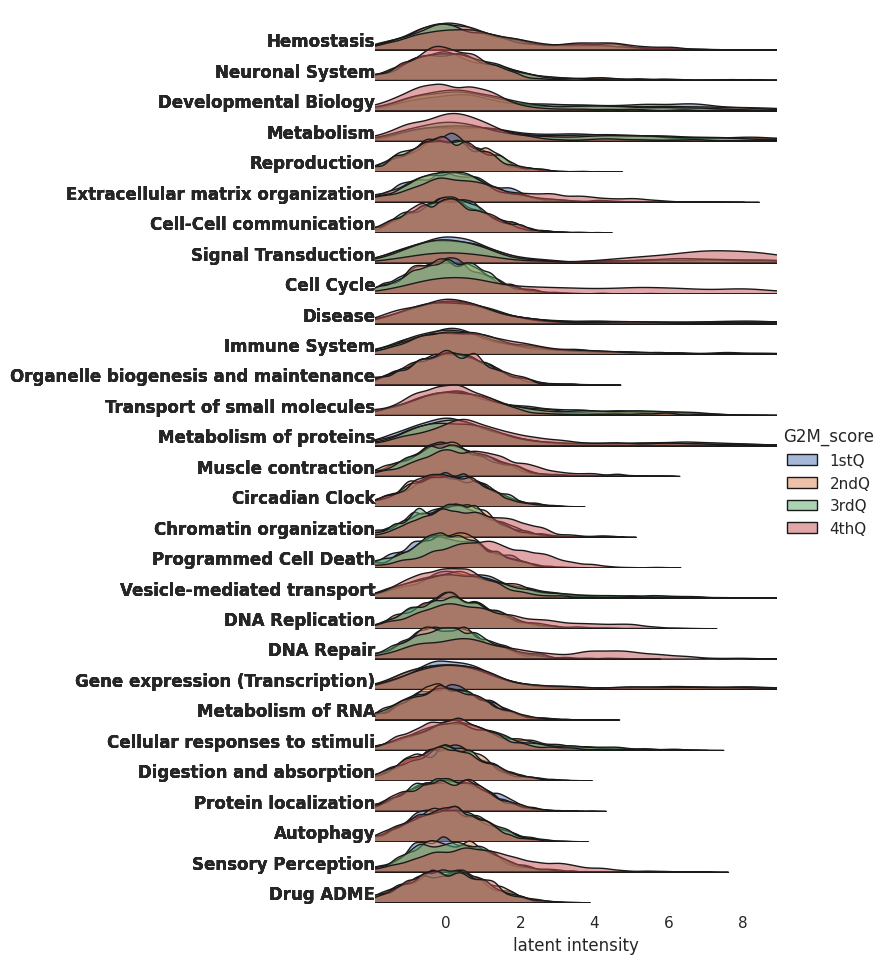

In [4]:
ridgeline_rea1 = Image(filename='reports/scRNA-velo/figures/latent_dist_G2M_score.png', width=600)

print("Latent intensitiy plot grouped by G2M score (cell cycle phase)")
display(ridgeline_rea1)

Indeed, we see that cells with high G2M-Scores (4th quantile) show a separation from cells with lower G2M-scores. This shows that we can gain insights by those explainable latent dimensions. So we can check also pathways associations and cell type clusters:

Latent intensitiy plot grouped by cell clusters


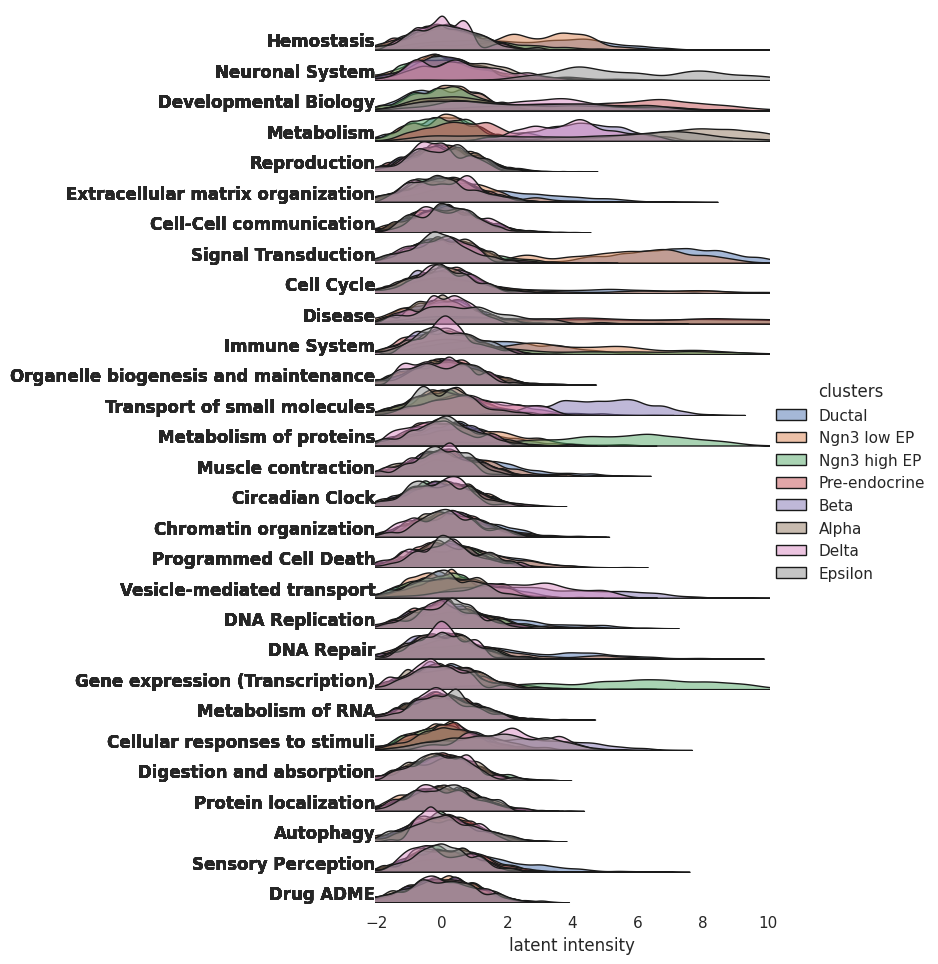

In [5]:
ridgeline_rea1 = Image(filename='reports/scRNA-velo/figures/latent_dist_clusters.png', width=600)

print("Latent intensitiy plot grouped by cell clusters")
display(ridgeline_rea1)

We can draw some interesting insights from that. For example, pancreas beta-cells, which primarly secrete insulin, are clearly distinct from other cells in the pathway 'Transport of small molecules'. Further, ductal cells, which secrete bicarbonate to neutralize stomach acidity, are well distinct in 'Signal Transduction'.